# Recitation 6: systems simulation with simpy

* Life sim

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

## Life Sim

Consider your friendly local TA. The TA works from 8 am to 6 pm every day.

* He has to grade 133 exams. Each exam takes a $U[5,15]$ minutes to grade.
* However, he also gets emails every now and then, according to a Poisson process with intensity $1/20\cos(t/180\pi)$ (t in minutes after 8 am, so average ~25 emails per day). Each email takes an exponential with mean 3 minutes to handle.
* Finally, he gets some push notifications at a constant rate of an average of 5 per hour. 95% of them cause take 1 minute to process, but 5% cause him to go on a 30 minute TikTok binge.

Emails interrupt exams, push notifications interrupt emails. When an exam is interrupted, the TA has to restart grading it from the start.

Write a simulator to estimate the number of exams the TA grades per day, and plot the distribution.

(Note: this is all tongue-in-cheek.)

In [2]:
left_to_grade = 133

def log(msg):
    pass #print(f"{env.now:7.2f}: {msg}")

def exams():
    global left_to_grade
    while True:
        try:
            rqt = brain.request(priority=2)
            log("Waiting for brain...")
            yield rqt
            log("Using brain to mark exam...")
            yield env.timeout(np.random.uniform(5, 15))
            log("Finished marking exam")
            brain.release(rqt)
            left_to_grade -= 1
        except simpy.Interrupt as intr:
            log("Got distracted from marking :(")

def email_intensity(t):
    return 1/20*np.cos(t/(180*np.pi))

def reply_to_email():
    try:
        rqt = brain.request(priority=1, preempt=True)
        yield rqt
        yield env.timeout(np.random.exponential(3))
        brain.release(rqt)
    except simpy.Interrupt as intr:
        log("Got distracted from replying to an email...")

def emails():
    while True:
        Lambda = 1/20
        inter_arrival = np.random.exponential(1/Lambda)
        yield env.timeout(inter_arrival)
        if np.random.rand() < email_intensity(env.now)/Lambda:
            log("Email incoming... hehehe")
            env.process(reply_to_email())

def process_notification():
    rqt = brain.request(priority=0, preempt=True)
    yield rqt
    if np.random.rand() < 0.95:
        log("normal, 1 minute distraction")
        yield env.timeout(1)
    else:
        log("big distraction")
        yield env.timeout(30)
    brain.release(rqt)

def notifications():
    # note: this is not according to the writeup. there is no way to receive a notification while
    # being on a TikTok™ binge: the arrival and service processes are interleaved
    while True:
        yield env.timeout(np.random.exponential(60/5))
        env.process(process_notification())

graded_per_day = []


for i in range(1_000):
    left_to_grade = 133
    env = simpy.Environment()
    brain = simpy.PreemptiveResource(env)
    env.process(exams())
    env.process(emails())
    env.process(notifications())
    env.run(until=1*600)
    graded_per_day.append(133 - left_to_grade)

# days = 0
# left_to_grade = 133
# while left_to_grade > 0:
#     env = simpy.Environment()
#     brain = simpy.PreemptiveResource(env)
#     env.process(exams())
#     env.process(emails())
#     env.process(notifications())
#     env.run(until=1*600)
#     days += 1

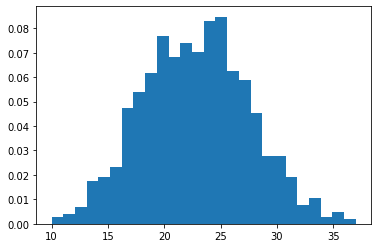

In [3]:
plt.hist(graded_per_day, density=True, bins=26);